In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="llama-3.1-8b-instant")
result=llm.invoke("Hello")
result

AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 36, 'total_tokens': 44, 'completion_time': 0.00976881, 'completion_tokens_details': None, 'prompt_time': 0.001928892, 'prompt_tokens_details': None, 'queue_time': 0.049985038, 'total_time': 0.011697702}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b99db-ccc4-7bd1-bfb9-649b05088848-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 36, 'output_tokens': 8, 'total_tokens': 44})

In [10]:
from typing import Annotated, List
import operator
from typing_extensions import Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict  

In [11]:
class Section(BaseModel):
    name:str=Field(description="Name for this section of the report")
    description:str=Field(description="Brief Overview of the main topic and concept of the section")

class Sections(BaseModel):
    section:List[Section]=Field(
        description="Sections of the report"
    )

In [12]:
planner=llm.with_structured_output(Sections)

In [13]:
planner

RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000002542C909AB0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002542C9099C0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'Sections', 'description': '', 'parameters': {'properties': {'section': {'description': 'Sections of the report', 'items': {'properties': {'name': {'description': 'Name for this section of the report', 'type': 'string'}, 'description': {'description': 'Brief Overview of the main topic and concept of the section', 'type': 'string'}}, 'required': ['name', 'description'], 'type': 'objec

In [16]:
from langgraph.constants import Send

class State(TypedDict):
    topic:str
    sections:list[Section]
    completed_section:Annotated[
        list, operator.add
    ]
    final_report:str


class WorkerState(TypedDict):
    section:Section
    completed_sections:Annotated[list,operator.add]

C:\Users\aswin\AppData\Local\Temp\ipykernel_34836\364709502.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [19]:
### Nodes

def orchestrator(state:State):
    """Orchestrator that generates a plan for the report """

    report_sections =  planner.invoke(
        [
            SystemMessage(content="Generate aplan for the report."),
            HumanMessage(content=f"Here is the report topic : {state['topic']}")
        ]
    )

    print("Report Sections: ", report_sections)
    return {"sections":report_sections.sections}

In [18]:
def llm_call(state: WorkerState):

    """ Worker write a section of the report """

    section = llm.invoke(
        [
            systemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting. "
            ),
            HumanMessage(
                content=f"Here is the section name : {state['section'].name} and description:{state['section'].description}"
            ),
        ]
    )

    return {"completed_sections":[section.content]}


def assign_workers(state:State):
    """Assign a worker to each section in the plan"""

    return [Send("llm_call", {"section":s}) for s in state["sections"]]


def synthesizer(state:State):

    """Synthesize full report from sections"""


    completed_sections = state["completed_sections"]
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report":completed_report_sections}



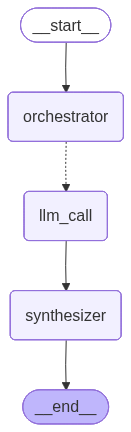

In [22]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
orchestrator_worker_builder = StateGraph(State)
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)
orchestrator_worker = orchestrator_worker_builder.compile()
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [23]:
from IPython.display import Markdown
state = orchestrator_worker.invoke({"topic": "Create a report on Agentic AI RAGs"})
Markdown(state["final_report"])

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<function=Sections> {"section":[{"name":"Introduction","description":"This section will provide an overview of the topic and concept of Agentic AI RAGs."},{"name":"Background","description":"This section will discuss the history and context of Agentic AI RAGs."},{"name":"Key Concepts","description":"This section will explain the core concepts and principles of Agentic AI RAGs."},{"name":"Methodology","description":"This section will outline the approach and methods used to analyze Agentic AI RAGs."},{"name":"Results","description":"This section will present the findings and results of the analysis of Agentic AI RAGs."},{"name":"Discussion","description":"This section will interpret the results and discuss the implications of Agentic AI RAGs."},{"name":"Conclusion","description":"This section will summarize the main points and provide recommendations."}]/function>'}}